In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Previous version (only protein emb, DNA LM data and sequence features used)
- seq_feats
- lm_3utr_emb
- lm_5utr_emb
- prot_emb

In [69]:
# DNA LM embeddings
#dnalm_df = pd.read_parquet('/s/project/multispecies/fungi_code/motif_discovery_pipeline/data/embeddings_non_sac_upstream/Saccharomyces_cerevisiae_BY4741/sequence_features_and_embeddings_Saccharomyces_cerevisiae_BY4741.parquet')
dnalm_df = pd.read_parquet('data/dnalm_df.parquet')
dnalm_df.head()

,gene_id,embedding_upstream,embedding_downstream,five_prime_seq,cds,three_prime_seq,gc_5_prime,gc_3_prime,gc_cds,AAA,...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,species
0,YAL002W,"[0.08123832, 0.030906273, 0.014586483, -0.0152...","[-0.02917197, 0.078893326, -0.05454025, 0.1706...",TTCCAAGGCCGATGAATTCGACTCTTTCCCAGCTGCCTCTGCTGCC...,ATGGAGCAAAATGGCCTTGACCACGACAGCAGATCTAGCATCGATA...,TAACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAA...,0.365902,0.310000,0.372057,0.043956,...,0.031397,0.0,0.010989,0.010989,0.009419,0.031397,0.013344,0.032967,0.032967,Saccharomyces_cerevisiae_BY4741
1,YAL003W,"[0.032580532, 0.025513712, -0.031748626, -0.04...","[-0.030835396, -0.072578646, -0.05808209, 0.14...",CTTCATGTCAGCCTGCACTTCTGGGTCGTTGAAGTTTCTACCGATC...,ATGGCATCCACCGATTTCTCCAAGATTGAAACTTTGAAACAATTAA...,TAAAAGGCTTTTTTATAAACTTTTTATAATTAACATTAAAGCAAAA...,0.372881,0.253333,0.448220,0.009709,...,0.029126,0.0,0.000000,0.014563,0.004854,0.014563,0.043689,0.038835,0.004854,Saccharomyces_cerevisiae_BY4741
2,YAL004W,"[0.07244772, -0.004530292, 0.08222245, -0.0672...","[-0.032747507, -0.1945743, -0.083140165, 0.042...",CCAATTTGTCACCAGCTTCAGAAATGGTGTTCTTCAAAGAGTAAGC...,ATGGGTGTCACCAGCGGTGGCCTTAACTTCAAAGATACCGTCTTCA...,TAAATCAATACCGACAGCTTTTGACATATTATCTGTTATTTACTTG...,0.417747,0.346667,0.451163,0.023256,...,0.018605,0.0,0.000000,0.023256,0.009302,0.000000,0.055814,0.032558,0.000000,Saccharomyces_cerevisiae_BY4741
3,YAL008W,"[0.018979808, 0.34264776, -0.0416448, 0.006748...","[0.0005224135, -0.061880764, -0.061566852, 0.1...",GTGTCCGGGCCTCGCAGGCGTTCTACTAGCAAGACATCCAGTGCGA...,ATGACTTTGGCTTTTAATATGCAACGGTTGGTGTTTCGTAATTTGA...,TGAGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCG...,0.381854,0.296667,0.388889,0.045455,...,0.020202,0.0,0.000000,0.015152,0.005051,0.055556,0.025253,0.065657,0.040404,Saccharomyces_cerevisiae_BY4741
4,YAL009W,"[-0.009528967, 0.003373141, 0.000113023896, -0...","[-0.01995761, -0.24868764, -0.054501917, 0.086...",CAAGATAATGTCAAAGTTAGTGGTCGTCCTGTGTTTGTAGAATGTG...,ATGGAGCCAGAGAGCATAGGCGATGTGGGGAACCATGCCCAGGATG...,TGAAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTA...,0.368893,0.323333,0.414414,0.042471,...,0.023166,0.0,0.000000,0.023166,0.007722,0.011583,0.027027,0.019305,0.038610,Saccharomyces_cerevisiae_BY4741


In [70]:
# Sequence features
seq_feats = dnalm_df[['gene_id'] + list(dnalm_df.iloc[:, 6:-1].columns)].dropna()
seq_feats.head()

,gene_id,gc_5_prime,gc_3_prime,gc_cds,AAA,AAC,AAG,AAT,ACA,ACC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,YAL002W,0.365902,0.310000,0.372057,0.043956,0.019623,0.018053,0.039246,0.013344,0.007849,...,0.006279,0.031397,0.0,0.010989,0.010989,0.009419,0.031397,0.013344,0.032967,0.032967
1,YAL003W,0.372881,0.253333,0.448220,0.009709,0.024272,0.077670,0.004854,0.000000,0.019417,...,0.000000,0.029126,0.0,0.000000,0.014563,0.004854,0.014563,0.043689,0.038835,0.004854
2,YAL004W,0.417747,0.346667,0.451163,0.023256,0.023256,0.000000,0.046512,0.004651,0.074419,...,0.000000,0.018605,0.0,0.000000,0.023256,0.009302,0.000000,0.055814,0.032558,0.000000
3,YAL008W,0.381854,0.296667,0.388889,0.045455,0.020202,0.040404,0.050505,0.015152,0.005051,...,0.000000,0.020202,0.0,0.000000,0.015152,0.005051,0.055556,0.025253,0.065657,0.040404
4,YAL009W,0.368893,0.323333,0.414414,0.042471,0.011583,0.023166,0.027027,0.011583,0.007722,...,0.003861,0.023166,0.0,0.000000,0.023166,0.007722,0.011583,0.027027,0.019305,0.038610


In [71]:
# Upstream sequence embedding
lm_5utr_emb = pd.DataFrame(np.stack(dnalm_df.dropna().embedding_upstream.values), index=dnalm_df.dropna().gene_id)
lm_5utr_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,0.081238,0.030906,0.014586,-0.015279,0.028113,0.121253,0.068083,0.171768,-0.014086,0.544913,...,-0.030622,-0.045234,-0.263034,0.105608,0.000841,-0.068895,0.092609,0.012248,0.040396,-0.008431
YAL003W,0.032581,0.025514,-0.031749,-0.042321,-0.052058,0.100852,-0.040193,0.227620,-0.041441,0.127843,...,-0.004374,-0.035856,-0.159351,0.127666,0.066430,-0.019931,0.045678,0.022475,-0.025326,-0.090283
YAL004W,0.072448,-0.004530,0.082222,-0.067203,-0.010486,-0.015001,0.229780,0.198991,-0.101902,0.422294,...,-0.029051,-0.134829,-0.129500,0.040292,0.037237,0.001085,0.122111,0.084727,0.389339,0.085969
YAL008W,0.018980,0.342648,-0.041645,0.006749,-0.031477,0.081134,0.195077,0.200070,-0.049627,0.392190,...,0.044176,-0.022111,-0.216389,0.075199,0.044513,-0.020134,0.051188,0.055149,-0.255109,-0.061252
YAL009W,-0.009529,0.003373,0.000113,-0.007516,-0.010976,0.063841,0.181502,0.260650,-0.035609,0.194044,...,-0.007081,0.005693,-0.196746,0.071950,0.073255,0.002211,0.107910,-0.004822,-0.406600,-0.065601


In [72]:
# Downstream sequence embedding
lm_3utr_emb = pd.DataFrame(np.stack(dnalm_df.dropna().embedding_downstream.values), index=dnalm_df.dropna().gene_id)
lm_3utr_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,-0.029172,0.078893,-0.054540,0.170680,-0.107067,-0.092142,0.094663,-0.073110,0.010419,0.073653,...,0.078681,0.033648,0.014682,-0.074566,0.052284,0.034215,0.132639,0.110446,-0.013290,0.052378
YAL003W,-0.030835,-0.072579,-0.058082,0.145516,0.149264,-0.134691,0.159887,-0.117146,0.021611,0.060180,...,0.033926,0.019848,-0.004159,-0.071930,0.093962,-0.118783,0.159958,0.053212,-0.016180,-0.016293
YAL004W,-0.032748,-0.194574,-0.083140,0.042409,-0.167408,-0.126880,0.001361,-0.057888,0.031826,0.058797,...,0.064126,0.029112,-0.026013,-0.039213,0.102791,-0.111031,0.153221,0.017565,0.043769,0.003665
YAL008W,0.000522,-0.061881,-0.061567,0.106177,0.190146,-0.093892,0.050411,-0.155466,-0.009316,-0.006226,...,0.088757,0.043351,-0.037464,-0.073037,0.038244,-0.024653,-0.003237,0.044000,0.024346,0.006319
YAL009W,-0.019958,-0.248688,-0.054502,0.086972,0.208853,0.028963,-0.019007,-0.138868,-0.011246,0.009775,...,0.073859,0.001456,-0.025106,-0.022704,0.054237,-0.049160,-0.003523,0.056109,-0.006815,0.032631


In [73]:
# Protein embeddings from ESM2
#dataset = pd.read_pickle("/s/project/semi_supervised_multispecies/Downstream/Sequences/Annotation/Sequences/saccharomyces_cerevisiae/all_w_protein_seqs_embs.pickle")
#prot_emb = pd.DataFrame(np.stack(dataset.protein_emb.dropna().values), index=dataset.gene_id)
prot_emb = pd.read_parquet('data/protein_emb.parquet')
prot_emb.head()

/Users/tristanaretz/mambaforge/envs/yeastEmbedding/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast


,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL037W,0.077271,-0.057495,0.052307,0.074829,0.021423,-0.085205,0.071228,0.095398,0.028702,0.050751,...,0.134277,0.072266,-0.021713,0.066406,0.005680,0.021194,0.082520,-0.128540,-0.082214,-0.041718
YAL016W,0.064758,0.026871,-0.037994,0.045532,-0.023880,-0.051514,0.044617,-0.152832,0.023239,0.023300,...,0.158203,0.056488,-0.054749,0.015411,-0.078064,0.029373,0.055328,-0.112305,-0.038544,0.107849
YAL003W,0.074219,-0.017822,-0.073120,0.050598,0.026871,0.065979,0.068481,-0.242920,0.031342,0.042450,...,0.030151,-0.015701,-0.027069,0.044128,-0.043304,-0.096680,-0.028107,-0.229614,-0.015327,0.076904
YAL053W,-0.002195,-0.014854,-0.033875,0.077026,-0.005131,-0.097351,0.085815,-0.107666,-0.033203,0.048950,...,0.139893,0.009560,-0.075989,0.025589,-0.024933,-0.044464,0.020859,-0.033234,-0.054749,0.038361
YAL031W-A,0.049866,0.035248,0.141846,0.016281,-0.022156,-0.022507,-0.046112,0.180176,0.170898,0.080444,...,0.090759,0.108032,-0.091125,0.139648,-0.069824,0.188232,0.010498,0.062744,-0.078430,0.033264


In [74]:
def zscore_matrix(mat):
    m = np.mean(np.array(mat, dtype=np.float32).flatten())
    sd = np.std(np.array(mat, dtype=np.float32).flatten())

    mat_z = (mat - m)/sd
    return mat_z

In [75]:
%%time

seq_feats = seq_feats.set_index('gene_id')
# seq_feats_z = zscore_matrix(seq_feats)
# seq_feats_z = seq_feats_z.reset_index()

prot_emb_z = zscore_matrix(prot_emb)
prot_emb_z.columns = prot_emb_z.columns.astype(str)
prot_emb_z.columns = 'ESM2_' + prot_emb_z.columns
prot_emb_z = prot_emb_z.reset_index()

lm_3utr_emb_z = zscore_matrix(lm_3utr_emb)
lm_3utr_emb_z.columns = lm_3utr_emb_z.columns.astype(str)
lm_3utr_emb_z.columns = 'LM_3UTR_' + lm_3utr_emb_z.columns
lm_3utr_emb_z = lm_3utr_emb_z.reset_index()

lm_5utr_emb_z = zscore_matrix(lm_5utr_emb)
lm_5utr_emb_z.columns = lm_5utr_emb_z.columns.astype(str)
lm_5utr_emb_z.columns = 'LM_5UTR_' + lm_5utr_emb_z.columns
lm_5utr_emb_z = lm_5utr_emb_z.reset_index()

# Merge all the embeddings to get a per gene S.cerevisiae embedding
yeast_emb_full = seq_feats.merge(prot_emb_z, on='gene_id').merge(lm_3utr_emb_z, on='gene_id').merge(lm_5utr_emb_z, on='gene_id')
yeast_emb_full

CPU times: user 179 ms, sys: 52.4 ms, total: 232 ms
Wall time: 229 ms


,gene_id,gc_5_prime,gc_3_prime,gc_cds,AAA,AAC,AAG,AAT,ACA,ACC,...,LM_5UTR_758,LM_5UTR_759,LM_5UTR_760,LM_5UTR_761,LM_5UTR_762,LM_5UTR_763,LM_5UTR_764,LM_5UTR_765,LM_5UTR_766,LM_5UTR_767
0,YAL002W,0.365902,0.310000,0.372057,0.043956,0.019623,0.018053,0.039246,0.013344,0.007849,...,-0.078495,-0.101951,-0.451596,0.140201,-0.027987,-0.139936,0.119334,-0.009675,0.035513,-0.042870
1,YAL003W,0.372881,0.253333,0.448220,0.009709,0.024272,0.077670,0.004854,0.000000,0.019417,...,-0.036358,-0.086898,-0.285149,0.175611,0.077306,-0.061331,0.043992,0.006744,-0.069993,-0.174272
2,YAL004W,0.417747,0.346667,0.451163,0.023256,0.023256,0.000000,0.046512,0.004651,0.074419,...,-0.075972,-0.245783,-0.237227,0.035347,0.030442,-0.027595,0.166694,0.106680,0.595686,0.108673
3,YAL008W,0.381854,0.296667,0.388889,0.045455,0.020202,0.040404,0.050505,0.015152,0.005051,...,0.041582,-0.064832,-0.376715,0.091384,0.042122,-0.061658,0.052838,0.059197,-0.438873,-0.127666
4,YAL009W,0.368893,0.323333,0.414414,0.042471,0.011583,0.023166,0.027027,0.011583,0.007722,...,-0.040703,-0.020197,-0.345180,0.086169,0.088264,-0.025787,0.143896,-0.037077,-0.682068,-0.134648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6574,YPR195C,0.334995,0.393333,0.467890,0.027523,0.000000,0.000000,0.027523,0.045872,0.009174,...,-0.069516,-0.091421,-0.402476,0.095457,0.023955,-0.072979,-0.082304,0.072628,-0.665834,0.037950
6575,YPR197C,0.376869,0.276667,0.374332,0.058824,0.021390,0.021390,0.016043,0.042781,0.005348,...,-0.014195,-0.102008,-0.424302,0.133435,0.087042,-0.024667,0.205772,0.009731,-0.687237,0.048592
6576,YPR199C,0.329013,0.283333,0.391156,0.030612,0.020408,0.047619,0.047619,0.027211,0.003401,...,0.052901,-0.037409,-0.385326,0.083647,0.060815,-0.034371,0.054171,0.069161,-0.484573,-0.094109
6577,YPR200C,0.366899,0.313333,0.376923,0.038462,0.015385,0.038462,0.023077,0.030769,0.015385,...,0.087128,-0.082817,-0.418286,0.099563,0.080339,-0.000032,0.105696,0.047736,-0.490977,0.055293


In [95]:

m = np.mean(np.array(lm_3utr_emb_z.iloc[:,1:], dtype=np.float32).flatten())
sd = np.std(np.array(lm_3utr_emb_z.iloc[:,1:], dtype=np.float32).flatten())
print(m,sd)

-1.1842807e-08 1.0000001


0.8445433873994512


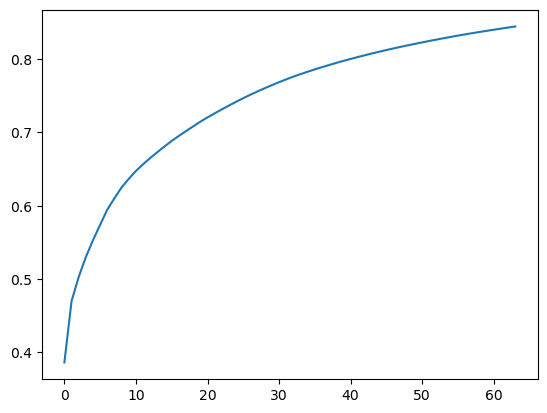

In [12]:
# Check what is the percentage of the variance explained by compressed data compared to the full data
N=64
pca = PCA(n_components=N)
pca.fit_transform(yeast_emb_full.iloc[:,1:])
ev = pca.explained_variance_ratio_.cumsum()
print(ev[-1])
plt.plot(range(0, N), ev)

In [13]:
dims = 64
emb_full_pca = pd.DataFrame(PCA(n_components=dims).fit_transform(yeast_emb_full.iloc[:,1:]), index=yeast_emb_full.gene_id).reset_index()
emb_full_pca

,gene_id,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,YAL002W,1.350518,-2.705953,-1.249147,-0.884463,0.093777,-3.918616,-1.101292,-0.525820,-0.365258,...,-0.348567,0.125675,0.061713,-0.081642,0.569481,-0.133986,0.301286,0.621461,0.274213,0.042009
1,YAL003W,7.801300,-1.138063,-0.104988,-1.874635,0.463608,4.607939,-0.764479,-2.198857,-1.092609,...,-0.211582,0.799364,-0.096410,-0.193297,-0.128080,-0.042956,0.385043,-0.348527,-0.600670,1.312991
2,YAL004W,-8.824801,5.049178,4.525735,-1.249379,-0.547005,0.965001,0.615475,0.441012,-0.987946,...,-0.911138,-0.399970,0.278703,-0.689540,0.076675,0.390431,1.593595,-0.413801,0.837168,0.858706
3,YAL008W,1.003984,-4.439332,-2.055461,-2.095814,-0.039439,-0.533439,-2.068278,-1.012841,-2.278583,...,0.059814,-0.249560,-0.060885,-0.264598,-0.143374,-0.107007,0.395480,-0.257224,0.159445,0.251521
4,YAL009W,0.317848,-2.682067,-1.796905,-0.984867,-0.965357,1.003266,-0.912031,1.055314,-0.916025,...,-0.341889,0.547692,0.113384,-0.276924,0.501516,0.197877,-0.216109,-0.757253,0.434325,-0.111781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6574,YPR195C,-12.959321,2.593324,-2.731855,1.928469,-0.405484,2.816277,1.141237,1.486669,-1.403696,...,0.744159,0.038506,1.335242,-0.617077,0.373119,-0.321214,-0.334855,0.579797,0.393785,-0.193018
6575,YPR197C,-10.684675,8.455941,6.477363,-4.848729,-0.594108,2.483717,-3.985001,-2.043341,3.759298,...,1.066363,1.004222,-0.813184,-0.049620,1.394921,1.332697,0.660168,-0.256326,0.379864,-0.283061
6576,YPR199C,-4.017440,-2.991633,0.940513,0.920400,0.986334,0.223407,-2.316896,0.581107,1.129787,...,-0.002245,-0.113246,0.213536,-0.111437,0.055978,0.195779,0.434420,0.443656,-0.587569,0.519917
6577,YPR200C,4.573682,-0.580103,-2.770326,-1.135877,0.678429,0.205747,-1.006403,-0.226968,0.700998,...,-0.227597,0.352815,-0.658722,-0.139042,-0.507068,0.850874,0.375345,-0.949256,0.713392,0.248744


# Load the data, that is needed to be incorporated as well
- experimental gene-gene interaction by Costazo et al 2016 
- gene expression and fitness data
- Yeast Net

In [14]:
# Gene expression and fitness data
data_experiment_decriptions= pd.read_csv('data/yp_screens_haphom_20221025.txt', sep = '\t', index_col = 0)
data_Turco = pd.read_csv('data/yp_matrix_z_haphom_20221025.txt', sep = '\t', index_col = 0)

In [15]:
# Gene-gene interactions, they need to be combined, cause separatedly for essential and non-essential genes
GxG_data_Costanzo_ExE = pd.read_csv('data/SGA_ExE_clustered.cdt', sep = '\t', dtype = 'str')
GxG_data_Costanzo_ExN = pd.read_csv('data/SGA_ExN_clustered.cdt', sep = '\t', dtype = 'str')
GxG_data_Costanzo_NxN = pd.read_csv('data/SGA_NxN_clustered.cdt', sep = '\t', dtype = 'str')

In [16]:
# Yeast Net data
YeastNetdata = pd.read_csv('data/YeastNet.csv', sep = ',', index_col = 0)

In [17]:
YeastNetdata.head()

,gene1,gene2,edge_value
0,YBL039C,YGR103W,3.713364
1,YDL060W,YDR101C,3.701611
2,YDL060W,YNL248C,3.693862
3,YDR101C,YOR004W,3.665467
4,YDL148C,YNL062C,3.660805


In [18]:
node_count = len(np.unique(np.concatenate([YeastNetdata.gene1, YeastNetdata.gene2])))
print(f"{len(YeastNetdata)/(node_count**2) * 100} % edges")

0.7386006109725306 % edges


In [19]:
YeastNetdata.to_csv("data/YeastNet.edg", sep="\t", columns=["gene1", "gene2", "edge_value"], header=False, index=False)

In [22]:
!pecanpy --input "data/YeastNet.edg" --output "data/YeastNetEmbeddings.npz" --mode SparseOTF --weighted

/opt/homebrew/lib/python3.10/site-packages/pecanpy/cli.py:302: UserWarning: When p = 1 and q = 1, it is highly recommended to use PreCompFirstOrder over SparseOTF (current selection). The runtime could be improved greatly with low memory usage.
  check_mode(g, args)
Took 00:00:00.47 to load Graph
Took 00:00:00.00 to pre-compute transition probabilities
Took 00:00:04.74 to generate walks
Took 00:00:05.57 to train embeddings


In [105]:
yeastnet_embeddings_npz = np.load("data/YeastNetEmbeddings.npz")
yeastnet_embeddings = pd.DataFrame(np.stack(yeastnet_embeddings_npz["data"]), index=yeastnet_embeddings_npz["IDs"]).add_prefix("yeastnet_")
yeastnet_embeddings

yeastnet_emb_z = zscore_matrix(yeastnet_embeddings)
yeastnet_emb_z.columns = yeastnet_emb_z.columns.astype(str)
yeastnet_emb_z = yeastnet_emb_z.reset_index()
yeastnet_emb_z.rename(columns={'index':'gene_id'}, inplace=True)

# m = np.mean(np.array(yeastnet_emb_z.iloc[:,1:], dtype=np.float32).flatten())
# sd = np.std(np.array(yeastnet_emb_z.iloc[:,1:], dtype=np.float32).flatten())
# print(m, sd)

yeastnet_emb_z

6.4701724e-09 1.0


,gene_id,yeastnet_0,yeastnet_1,yeastnet_2,yeastnet_3,yeastnet_4,yeastnet_5,yeastnet_6,yeastnet_7,yeastnet_8,...,yeastnet_118,yeastnet_119,yeastnet_120,yeastnet_121,yeastnet_122,yeastnet_123,yeastnet_124,yeastnet_125,yeastnet_126,yeastnet_127
0,YBR247C,1.154001,-2.323598,0.291287,0.541442,-0.110299,0.077236,-1.844938,1.867743,1.161905,...,0.298586,-0.028804,0.407689,-0.179159,-0.638003,1.042853,-0.335829,0.277630,0.794885,-1.844804
1,YDL060W,0.606994,-2.701933,0.241321,1.546832,0.646566,1.111178,-1.405780,2.041628,0.996153,...,0.524328,-1.106095,0.417876,-1.300562,0.149243,1.532837,-0.490236,0.222103,0.940382,-1.658142
2,YBR142W,0.741882,-2.112988,0.191977,1.067056,-0.061810,0.380645,-1.279152,1.312763,1.198114,...,0.100012,-1.185547,0.242482,-0.623613,-0.097805,1.014064,-0.334305,0.334455,-0.163962,-1.659734
3,YBL039C,1.105821,-2.034642,0.585185,1.361523,-0.087029,0.169074,-2.034025,1.711104,1.079246,...,0.306820,-0.734821,0.751689,-0.629925,-1.032752,0.944071,-0.515061,1.050003,0.368747,-1.374252
4,YAL059W,0.134755,-1.723604,-0.371440,1.705739,0.028935,-0.328955,-1.640893,2.234356,1.178882,...,-0.110458,-0.550406,0.327011,-0.808194,-0.070067,2.421203,-0.022336,-0.508722,0.641553,-1.108357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5725,YGR121W-A,-0.124103,0.911706,-0.125730,-0.394081,-0.681440,-0.051626,-0.133157,1.339184,1.035561,...,0.258300,0.047836,-0.912902,-0.506043,-0.085696,0.783886,-0.393857,-0.349241,0.103931,-0.236222
5726,YMR244W,0.029425,-0.412771,-0.689175,0.318610,0.057673,0.284743,-0.486957,0.971882,0.510673,...,-0.162124,-0.502530,-0.289327,-0.161753,-0.582411,0.772142,0.030162,-0.080346,0.397178,-0.592815
5727,YOR112W,-0.027083,0.072115,-0.120002,-0.042179,-0.255865,-0.070852,-0.300311,1.097954,0.865022,...,-0.050942,-0.349832,-0.301733,-0.192561,-0.483338,0.633717,-0.155742,-0.099778,0.295125,-0.412914
5728,YIR018C-A,-0.390121,0.193368,-0.257834,0.086667,-0.586071,-0.030564,-0.054926,0.151665,0.404882,...,-0.546451,-0.093370,-0.551646,-0.050211,-0.704189,0.820156,-0.334337,0.142760,0.329598,-0.104198


In [157]:
# Merge all the embeddings to get a per gene S.cerevisiae embedding
yeast_emb_full = seq_feats.merge(yeast_emb_full, on='gene_id').merge(yeastnet_emb_z, on='gene_id')
yeast_emb_full

,gene_id,gc_5_prime_x,gc_3_prime_x,gc_cds_x,AAA_x,AAC_x,AAG_x,AAT_x,ACA_x,ACC_x,...,yeastnet_118,yeastnet_119,yeastnet_120,yeastnet_121,yeastnet_122,yeastnet_123,yeastnet_124,yeastnet_125,yeastnet_126,yeastnet_127
0,YAL002W,0.365902,0.310000,0.372057,0.043956,0.019623,0.018053,0.039246,0.013344,0.007849,...,-0.688430,0.453357,-0.952871,0.583605,-1.071790,1.505447,-1.573974,0.990732,-0.189181,0.700220
1,YAL003W,0.372881,0.253333,0.448220,0.009709,0.024272,0.077670,0.004854,0.000000,0.019417,...,-0.353126,-1.673560,0.675055,0.732117,-1.335621,0.100818,-0.360148,-0.074318,2.274706,-1.300483
2,YAL008W,0.381854,0.296667,0.388889,0.045455,0.020202,0.040404,0.050505,0.015152,0.005051,...,-0.694375,0.092803,0.080423,0.764728,-1.180482,1.230487,-1.522250,0.782980,-0.381039,0.290796
3,YAL009W,0.368893,0.323333,0.414414,0.042471,0.011583,0.023166,0.027027,0.011583,0.007722,...,0.029251,0.018426,-1.270366,-0.273565,-0.801865,-0.279575,0.029312,0.337151,0.917920,-0.041222
4,YAL011W,0.461615,0.346667,0.416533,0.078400,0.014400,0.057600,0.030400,0.009600,0.019200,...,-0.365933,-0.441461,-0.903892,0.162985,-1.112002,-0.237180,-0.209272,0.577356,0.043828,0.372426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679,YPR190C,0.408774,0.323333,0.388889,0.048930,0.019878,0.032110,0.027523,0.019878,0.013761,...,-0.017842,-1.070176,0.536994,-1.065814,-1.464119,0.937825,-0.335918,0.204133,1.056733,-2.030319
5680,YPR193C,0.356929,0.363333,0.412393,0.051282,0.051282,0.038462,0.012821,0.006410,0.012821,...,-1.492557,-0.011383,-1.357792,0.742979,-1.459550,2.104283,-0.444645,-0.403210,0.391995,0.365726
5681,YPR194C,0.347956,0.323333,0.373242,0.037628,0.013683,0.019384,0.041049,0.017104,0.009122,...,-0.821638,-0.524756,-0.373523,0.499321,-1.331243,0.664545,-0.241034,0.696831,0.244292,0.130683
5682,YPR199C,0.329013,0.283333,0.391156,0.030612,0.020408,0.047619,0.047619,0.027211,0.003401,...,-0.723075,-0.319677,-1.048941,-0.261804,-0.972994,0.570057,0.382860,0.555029,-0.402626,0.325634


0.8209376291925621


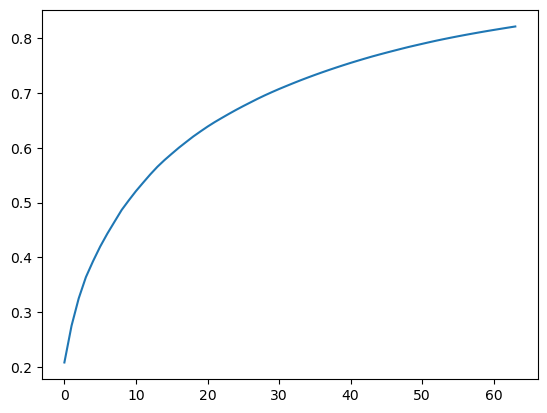

In [158]:
# Check what is the percentage of the variance explained by compressed data compared to the full data
N=64
pca = PCA(n_components=N)
pca.fit_transform(yeast_emb_full.iloc[:,1:])
ev = pca.explained_variance_ratio_.cumsum()
print(ev[-1])
plt.plot(range(0, N), ev)

In [159]:
dims = 64
emb_full_pca = pd.DataFrame(PCA(n_components=dims).fit_transform(yeast_emb_full.iloc[:,1:]), index=yeast_emb_full.gene_id).reset_index()
emb_full_pca.columns = emb_full_pca.columns.astype(str)
emb_full_pca

,gene_id,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,YAL002W,-1.663593,3.879036,0.497458,-1.280751,0.079232,1.114175,-2.621820,-0.148753,-0.124612,...,-0.691677,0.293062,-2.514088,-1.500890,0.205773,-0.472836,-1.654978,-0.245660,-1.263847,-1.288679
1,YAL003W,7.752606,-7.056500,-5.084725,-4.797162,1.549019,-1.052974,-2.096365,-0.664042,-1.452823,...,-0.430454,-0.103098,0.211956,-0.436164,0.988518,-0.056236,-0.138577,0.008716,0.506206,-0.470507
2,YAL008W,-1.585457,3.621998,-1.538734,-6.454099,-1.535286,1.229331,-2.079352,-1.666980,-0.305915,...,-1.046544,0.425878,-0.760757,-1.902454,1.440829,-0.694840,0.743680,-0.614564,-1.216887,-0.578270
3,YAL009W,-2.032449,-0.560727,2.581579,-2.224993,-2.076195,-3.751376,-0.465315,3.076335,2.126232,...,0.336405,0.139003,0.736425,-0.153291,-0.565689,0.266517,0.828651,-0.221627,0.052453,-0.211140
4,YAL011W,-8.339460,-2.815677,1.352787,-3.030879,3.094129,0.060690,0.429359,0.581893,-1.050112,...,0.560717,-0.881949,0.082073,-0.634485,-0.176240,0.141805,0.270838,-0.152002,-0.696503,-0.676596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679,YPR190C,-0.429498,-7.579556,1.126636,0.047687,-0.251608,4.073207,0.109997,-1.423992,-0.822376,...,1.137440,-0.190272,-0.152763,-1.063880,0.190764,-0.269669,-0.478313,0.217445,0.379490,0.033834
5680,YPR193C,7.444189,6.101313,-0.647654,-0.290064,-1.665448,1.052747,0.770136,-1.223965,-1.603298,...,0.885530,0.001784,-0.733059,1.316148,0.042072,1.179697,0.237652,-0.704440,0.545270,0.420717
5681,YPR194C,5.958484,1.865083,-0.422444,4.062137,1.197021,1.297348,-3.091233,-0.779657,4.307650,...,-1.367026,-1.261689,-0.744038,0.041038,-0.318749,0.629370,-0.091930,0.906936,0.094124,1.911963
5682,YPR199C,-7.193497,2.510054,0.065730,0.520332,0.602247,0.735181,-1.131250,-1.256500,-0.459015,...,-0.412678,-0.511900,-0.334054,1.636504,0.447122,0.187707,-0.678425,0.141420,-0.699529,0.185382


# Simple evaluation on siingle mutant fitness data

In [160]:
# Read in single mutant fitness data from Constanzo et al. 2016
smf_filter = pd.read_csv('data/smf.csv', index_col = 0)

<Axes: >

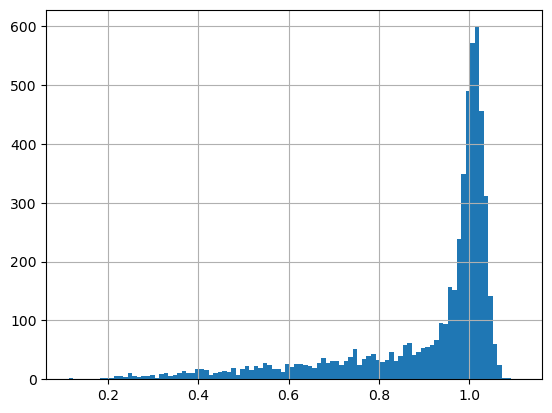

In [161]:
smf_filter.smf_30.hist(bins=100)

In [162]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

R2:  0.20027807566516498


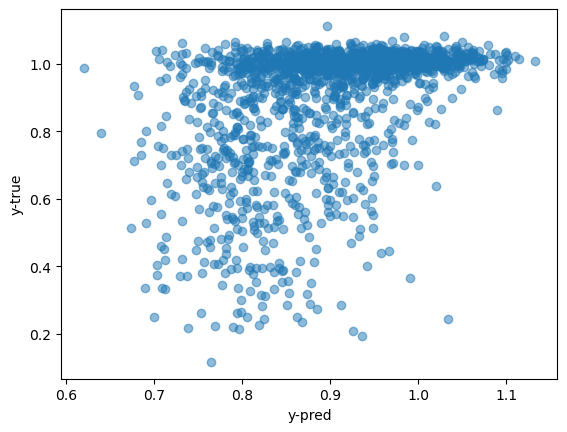

In [163]:
# How predictive are sequence features?

A = smf_filter.merge(emb_full_pca, on='gene_id').dropna()
X = A.iloc[:, 5:]
y = A['smf_30']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lm = LinearRegression().fit(X_train, y_train)
print('R2: ', lm.score(X_test, y_test))

plt.scatter(lm.predict(X_test), y_test, alpha=0.5)
plt.xlabel("y-pred")
plt.ylabel("y-true")
plt.show()